In [193]:
from TTS.utils.synthesizer import Synthesizer
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [194]:
tts_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/model_file.pth"
tts_config_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/config.json"
speakers_file_path = "/Users/tindelllockett/Library/Application Support/tts/tts_models--en--vctk--vits/speaker_ids.json"

In [195]:
# Define text, model name, speaker index, and output path
text = "hello world; this is an example sentence"
speaker_idx = "p225"
out_path = "out.wav"

In [218]:


# Initialize the synthesizer
synthesizer = Synthesizer(
        tts_checkpoint=tts_path,
        tts_config_path=tts_config_path,
        tts_speakers_file=speakers_file_path,
        use_cuda=False,
    );



 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [197]:
synthesizer.tts_model.speaker_manager.speaker_names[:4]

['ED\n', 'p225', 'p226', 'p227']

In [198]:
output = synthesizer.tts(text=text,speaker_name="p225",return_extra_outputs=True)
Audio(output[0], rate=22050)

 > Text splitted to sentences.
['hello world; this is an example sentence']
 > Processing time: 0.7584009170532227
 > Real-time factor: 0.23577064376584084


In [200]:
tokens = synthesizer.tts_model.tokenizer.text_to_ids(text)
pre_tokenized_text_blnk = [synthesizer.tts_model.tokenizer.decode([y]) for y in tokens]
# replace <blnk> with space
pre_tokenized_text = [x if x != '<BLNK>' else '_' for x in pre_tokenized_text_blnk]
space_indices = [i for i, phoneme in enumerate(pre_tokenized_text) if phoneme == ' ']
space_indices = [0] + space_indices
space_indices


[0, 13, 29, 37, 43, 49, 69]

In [201]:
phoneme_durations = output[1]['outputs']['durations'].squeeze()
phoneme_timestamps = np.cumsum(phoneme_durations.squeeze())
phoneme_durations



tensor([ 1.,  2.,  2.,  2.,  2.,  7.,  2.,  4.,  1.,  2.,  2.,  1.,  3.,  2.,
         5.,  2.,  1.,  5.,  3.,  3.,  1.,  6.,  1.,  2.,  5.,  2.,  2.,  2.,
         4.,  1.,  2.,  2.,  3.,  2.,  2.,  2.,  2.,  4.,  2.,  2.,  2.,  3.,
         1.,  1.,  3.,  1.,  1.,  1.,  3.,  1.,  4.,  1.,  3.,  1.,  3.,  2.,
         1.,  6.,  2.,  3.,  3.,  1.,  4.,  2.,  1.,  5.,  2.,  1.,  1.,  2.,
         5.,  3.,  2.,  3.,  1.,  2.,  3.,  1.,  4.,  3.,  2.,  9.,  2.,  3.,
         4.,  9., 16.])

In [202]:
word_timestamps = []
start_idx = 0
word_timestamps = [float(phoneme_timestamps[space_idx]) for space_idx in space_indices]
word_timestamps[0] = 0.0

word_timestamps

[0.0, 33.0, 78.0, 97.0, 108.0, 118.0, 166.0]

In [203]:
# zip pre_tokenized_text and phoneme_timestamps
paired_tokens_timestamps = list(zip(pre_tokenized_text, phoneme_timestamps))
paired_tokens_timestamps[:14]

[('_', tensor(1.)),
 ('h', tensor(3.)),
 ('_', tensor(5.)),
 ('ə', tensor(7.)),
 ('_', tensor(9.)),
 ('l', tensor(16.)),
 ('_', tensor(18.)),
 ('ˈ', tensor(22.)),
 ('_', tensor(23.)),
 ('o', tensor(25.)),
 ('_', tensor(27.)),
 ('ʊ', tensor(28.)),
 ('_', tensor(31.)),
 (' ', tensor(33.))]

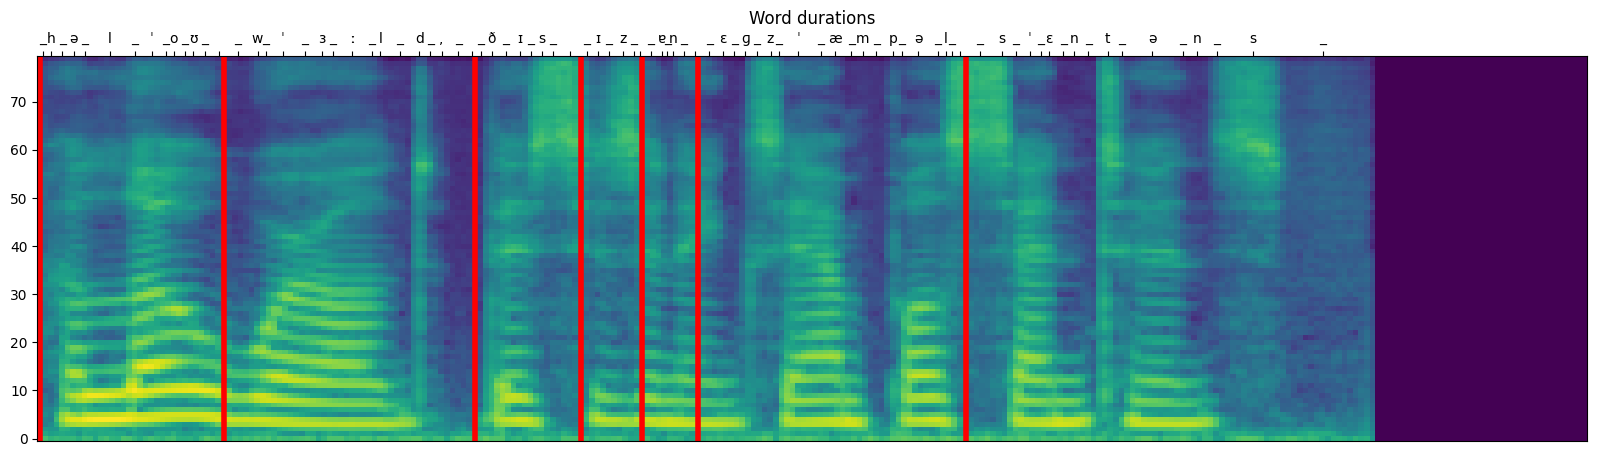

In [204]:
# plot the spectrogram
spec = synthesizer.tts_model.ap.melspectrogram(np.array(output[0]))

# plot the spectrogram with xticks
spec = synthesizer.tts_model.ap.melspectrogram(np.array(output[0]))
plt.figure(figsize=(20,5))
plt.imshow(spec, origin="lower", aspect='auto', interpolation='none')
# create labels at the xticks
# plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()), pre_tokenized_text, rotation=0)
# shift the xticks to the middle of the bins
plt.xticks(np.cumsum(output[1]["outputs"]["durations"].cpu().numpy()[0][0]) - output[1]["outputs"]["durations"].cpu().numpy()[0][0] / 2, pre_tokenized_text, rotation=0)
# draw a vertical line for each token
for x in word_timestamps:
    plt.axvline(x, color="red", linewidth=4)

plt.gca().xaxis.tick_top()
plt.title("Word durations")
plt.show()

In [213]:
beep = np.sin(2 * np.pi * 1000 * np.arange(0, 0.1, 1/22050))
len(beep)
Audio(beep, rate=22050)

In [214]:
# Get the audio samples from the synthesizer
audio_samples = np.array(output[0])

# Convert the word start timestamps to sample indices
word_sample_indices = [int(start * 22050) for start in word_timestamps]

# Insert the beep at each word start
for start_sample in word_sample_indices:
    print(f"Start sample: {start_sample}") # Print start sample
    end_sample = start_sample + len(beep)
    print(f"End sample before check: {end_sample}") # Print end sample before the check
    if end_sample > len(audio_samples):
        end_sample = len(audio_samples)
        # beep = beep[:end_sample - start_sample]  # Truncate beep if necessary
    print(f"End sample after check: {end_sample}") # Print end sample after the check
    print(f"Length of audio_samples: {len(audio_samples)}") # Print length of audio samples
    print(f"Length of beep: {len(beep)}") # Print length of beep
    audio_samples[start_sample:end_sample] += beep

    print(f"Audio samples at start_sample to end_sample: {audio_samples[start_sample:end_sample]}") # Print the samples at the current slice

# Play the modified audio
Audio(audio_samples, rate=22050)



Start sample: 0
End sample before check: 2205
End sample after check: 2205
Length of audio_samples: 70928
Length of beep: 2205
Audio samples at start_sample to end_sample: [ 0.00200452  0.2828564   0.54126893 ... -0.72764893 -0.50329928
 -0.23455873]
Start sample: 727650
End sample before check: 729855
End sample after check: 70928
Length of audio_samples: 70928
Length of beep: 2205


ValueError: operands could not be broadcast together with shapes (0,) (2205,) (0,) 

In [228]:
# Check the conversion from timestamps to samples
# for timestamp in word_timestamps:
#     start_sample = timestamp * 22050
#     print(f"Start sample: {start_sample}")

#     # Verify that the start_sample is within the bounds of audio_samples
#     if start_sample >= len(audio_samples):
#         print("Start sample out of bounds!")

#     # Check if start_sample + len(beep) is within bounds
#     if start_sample + len(beep) > len(audio_samples):
#         print("End sample out of bounds!")
# print(phoneme_timestamps)
# print(len(audio_samples))
# print(len(beep))
sample_rate = 22050  # Ensure this is the correct sample rate for the audio
audio_duration = len(audio_samples) / sample_rate

# Verify that the maximum word timestamp is consistent with the audio duration
max_timestamp = max(word_timestamps)
if max_timestamp > audio_duration:
    print(f"Error: max timestamp {max_timestamp} exceeds audio duration {audio_duration}")

# Convert word timestamps to sample indices
word_sample_indices = [(int(start * sample_rate)) for start in word_timestamps]

# Now you can insert the beep at the word sample indices
for start_sample in word_sample_indices:
    if start_sample + len(beep) > len(audio_samples):
        end_sample = len(audio_samples)
    audio_samples[start_sample:end_sample] += beep[:end_sample - start_sample]



Error: max timestamp 166.0 exceeds audio duration 3.2166893424036282


TypeError: cannot unpack non-iterable int object